In [1]:
import pandas as pd
import numpy as np

import time


import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split, KFold

import xgboost as xgb
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt

Подготовленный датасет можно скачать https://drive.google.com/file/d/1HV0jxHCrqkV8pMu-njYSYVAOlzxbJHcA/view?usp=sharing

In [ ]:
data = pd.read_pickle('dataset_finished_2.pkl')

In [2]:
data = pd.read_pickle('dataset_finished_2.pkl')

In [3]:
def feature_concatenation(df, features):
    new_name = f'{features[0]}'
    data = df[new_name].astype('str')
    for i in range(1, len(features)):
        new_name += f'_{features[i]}'
        df[features[i]] = df[features[i]].astype('str')
        data += ' _ ' + df[features[i]]
        
    return data

In [4]:
data['ID'] = feature_concatenation(data, ['prod_norm_name', 'prod_form_norm_name', 'prod_d_norm_name', 'prod_pack_1_2', 'prod_pack_1_size'])

In [5]:
data.sample(2)

,year_,month_,prod_norm_name,prod_form_norm_name,prod_d_norm_name,prod_pack_1_2,prod_pack_1_size,ЖНВЛП,Ковид,origin,...,name,max_3,min_3,avg_3,Count_3,region_name,population,covid,ORVI,ID
12132,2021,1,МНН №544,МАЗЬ ДЛЯ НАРУЖНОГО ПРИМЕНЕНИЯ,0.5 %,1,10.0,Да,Нет,1,...,Ленинградская область,NaN,NaN,NaN,NaN,Ленинградская область,1894038,6861,44545,МНН №544 _ МАЗЬ ДЛЯ НАРУЖНОГО ПРИМЕНЕНИЯ _ 0.5...
252668,2021,7,МНН №1274,КАПСУЛЫ,НЕ УКАЗАНО,2,10.0,Нет,Нет,2,...,Санкт-Петербург,NaN,NaN,NaN,NaN,Санкт-Петербург,5388759,59373,117064,МНН №1274 _ КАПСУЛЫ _ НЕ УКАЗАНО _ 2 _ 10.0


In [6]:
data_Len = data.loc[data['name']=='Ленинградская область']
data_Len = data_Len.set_index('ID')

In [7]:
data_Len.sample(2)

,year_,month_,prod_norm_name,prod_form_norm_name,prod_d_norm_name,prod_pack_1_2,prod_pack_1_size,ЖНВЛП,Ковид,origin,code,name,max_3,min_3,avg_3,Count_3,region_name,population,covid,ORVI
ID,,,,,,,,,,,,,,,,,,,,
МНН №478 _ КАПСУЛЫ _ 250 мг _ 4 _ 25.0,2021,9,МНН №478,КАПСУЛЫ,250 мг,4,25.0,Да,Нет,1,47,Ленинградская область,NaN,NaN,NaN,NaN,Ленинградская область,1894038,6118,59850
МНН №1039 _ ТАБЛЕТКИ _ 250 мг _ 12 _ 10.0,2021,5,МНН №1039,ТАБЛЕТКИ,250 мг,12,10.0,Да,Нет,1,47,Ленинградская область,NaN,NaN,NaN,NaN,Ленинградская область,1894038,2667,31677


In [8]:
columns_to_drop = ['year_', 'name', 'prod_norm_name', 'prod_form_norm_name', 
                   'prod_d_norm_name', 'prod_pack_1_2', 'prod_pack_1_size', 'region_name',]

data_Len = data_Len.drop(columns=columns_to_drop, axis=1)

In [9]:
mapping = {
    'Нет': 0,
    'Да' : 1,
}

data_Len['ЖНВЛП'] = data_Len['ЖНВЛП'].map(mapping)
data_Len['Ковид'] = data_Len['Ковид'].map(mapping)

In [10]:
# Отношение мешду населением и покупками
data_Len['Sales_population'] = data_Len['Count_3'] / data_Len['population']
data_Len['Sales_population_money'] = data_Len['Count_3'] * data_Len['avg_3'] / data_Len['population']
# Отношение между заболевшими и покупками
data_Len['Sales_covid'] = data_Len['Count_3'] / data_Len['covid']
data_Len['Sales_ORVI'] = data_Len['Count_3'] / data_Len['ORVI']

In [11]:
data_Len.sample(3)

,month_,ЖНВЛП,Ковид,origin,code,max_3,min_3,avg_3,Count_3,population,covid,ORVI,Sales_population,Sales_population_money,Sales_covid,Sales_ORVI
ID,,,,,,,,,,,,,,,,
МНН №705 _ ТАБЛЕТКИ _ 175 мг + 175мг _ 2 _ 10.0,9,0,0,1,47,NaN,NaN,NaN,NaN,1894038,6118,59850,NaN,NaN,NaN,NaN
МНН №1139 _ ПОРОШОК ДЛЯ ПРИГОТОВЛЕНИЯ РАСТВОРА ДЛЯ ВНУТРИВЕННОГО И ВНУТРИМЫШЕЧНОГО ВВЕДЕНИЯ _ 0.5 г _ 1 _ 500.0,10,0,0,1,47,NaN,NaN,NaN,NaN,1894038,9346,62596,NaN,NaN,NaN,NaN
МНН №1720 _ РАСТВОР ДЛЯ ВНУТРИВЕННОГО И ПОДКОЖНОГО ВВЕДЕНИЯ _ 600 мкг/мл (60 млн. МЕ/мл) _ 5 _ 0.8,5,1,0,1,47,NaN,NaN,NaN,NaN,1894038,2667,31677,NaN,NaN,NaN,NaN


In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    data_Len.drop('Count_3', axis=1), data_Len['Count_3'], train_size=0.2, shuffle=True, random_state=1,
)
y_train = y_train.replace(np.nan, 0)
y_test = y_test.replace(np.nan, 0)

In [13]:
xgb_reg = xgb.XGBRegressor(n_estimators=10000, 
                           max_depth=6, 
                           eta=0.01, 
                           subsample=0.7, 
                           colsample_bytree=0.8)

In [14]:
xgb_reg.fit(x_train, y_train)

y_pred = xgb_reg.predict(x_test).astype(int)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)

R_squared = r2(y_test, y_pred)

print("RMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))


RMSE:  859.1

R-Squared:  0.93


In [15]:
group_data = data_Len.groupby('month_').mean()
group_data

,ЖНВЛП,Ковид,origin,code,max_3,min_3,avg_3,Count_3,population,covid,ORVI,Sales_population,Sales_population_money,Sales_covid,Sales_ORVI
month_,,,,,,,,,,,,,,,
1,0.565160,0.023295,1.344489,47.0,68610.762200,48017.808313,59285.326303,1166.961952,1894038.0,6861.0,44545.0,0.000616,19.640525,0.170086,0.026197
2,0.565212,0.023292,1.344448,47.0,74735.991881,50306.289986,63242.827064,2476.009743,1894038.0,5234.0,44423.0,0.001307,35.118427,0.473063,0.055737
3,0.565212,0.023292,1.344448,47.0,55421.831692,47229.189639,51914.317862,92.715893,1894038.0,3804.0,40692.0,0.000049,1.496423,0.024373,0.002278
4,0.565160,0.023295,1.344489,47.0,58537.186916,46351.932548,53885.741568,85.329541,1894038.0,2706.0,25889.0,0.000045,1.429122,0.031533,0.003296
5,0.565160,0.023295,1.344489,47.0,56527.937233,44543.104184,52229.216055,93.834757,1894038.0,2667.0,31677.0,0.000050,1.546238,0.035184,0.002962
6,0.565212,0.023292,1.344448,47.0,55236.789300,43371.411728,51037.495885,115.820576,1894038.0,3625.0,30304.0,0.000061,1.808965,0.031951,0.003822
7,0.565160,0.023295,1.344489,47.0,47012.882379,35913.526211,42132.181057,94.517621,1894038.0,7374.0,26146.0,0.000050,1.414574,0.012818,0.003615
8,0.565212,0.023292,1.344448,47.0,47421.034710,38138.336336,43529.737258,97.647188,1894038.0,6968.0,56998.0,0.000052,1.549172,0.014014,0.001713
9,0.565212,0.023292,1.344448,47.0,72805.984238,56730.061671,64454.443332,362.246185,1894038.0,6118.0,59850.0,0.000191,6.181912,0.059210,0.006053


<AxesSubplot:ylabel='month_'>

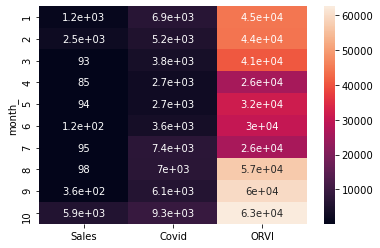

In [16]:
data_map = pd.DataFrame()
data_map['Sales'] = group_data['Count_3']
data_map['Covid'] = group_data['covid']
data_map['ORVI'] = group_data['ORVI']

sns.heatmap(data_map, annot=True)

<AxesSubplot:xlabel='month_'>

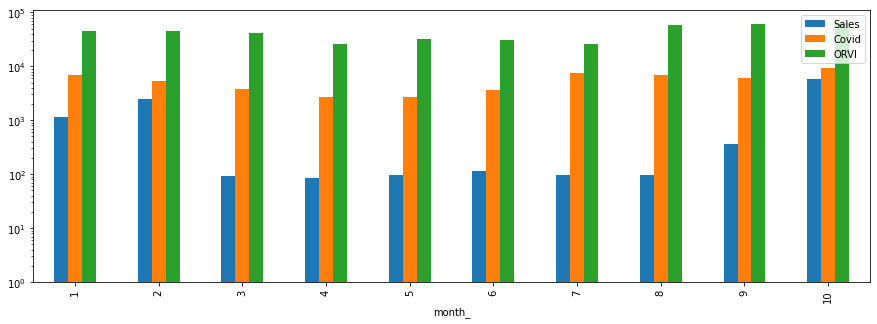

In [17]:
data_map.plot.bar(figsize=(15, 5), log=True)

In [18]:
data_map.corr()

,Sales,Covid,ORVI
Sales,1.000000,0.627125,0.555385
Covid,0.627125,1.000000,0.658173
ORVI,0.555385,0.658173,1.000000


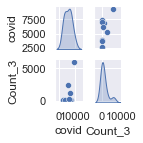

In [19]:
sns.set()
columns = ["covid", "Count_3"]

sns.pairplot(group_data[columns], size=1, kind="scatter", diag_kind="kde")
plt.show()

<AxesSubplot:xlabel='covid', ylabel='Count_3'>

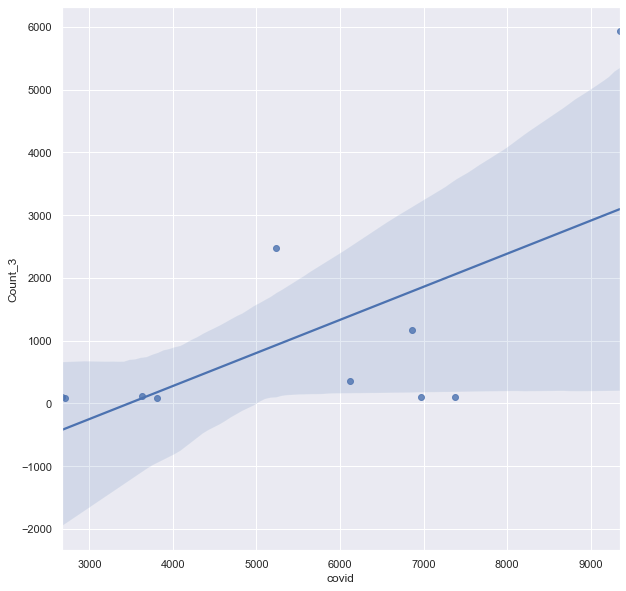

In [20]:
data = group_data[["covid", "Count_3"]]
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

sns.regplot(
    x="covid",
    y="Count_3",
    data=data,
    ax=axes
)

<AxesSubplot:xlabel='ORVI', ylabel='Count_3'>

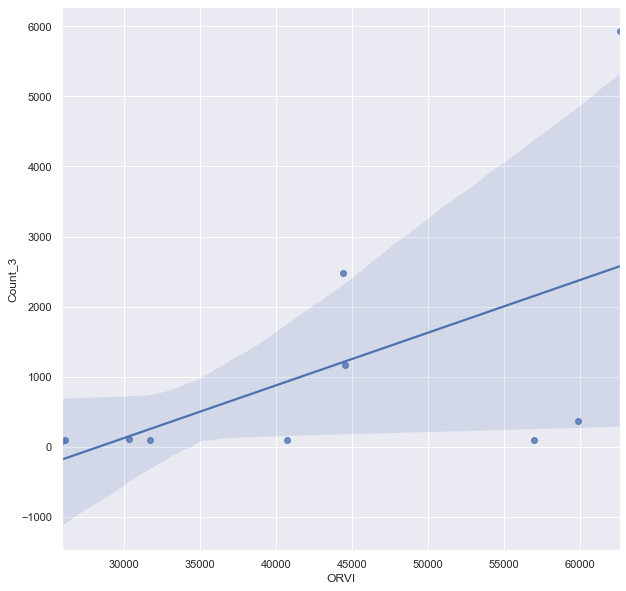

In [22]:
data = group_data[["ORVI", "Count_3"]]
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

sns.regplot(
    x="ORVI",
    y="Count_3",
    data=data,
    ax=axes
)